<a href="https://colab.research.google.com/github/JoshuHwa/medical-AI_SNUH/blob/main/%EB%B0%94%EC%9D%B4%EC%98%A4%EC%95%84%EC%B9%B4%EB%8D%B0%EB%AF%B8_%EC%A0%95%ED%98%95%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%8B%A4%EC%8A%B5_%EA%B0%95%EC%9D%98%EC%9A%A9_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Prelim: GPU setup**

In [1]:
# visualize current GPU usages in your server
!nvidia-smi

Fri Aug  9 06:12:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# set gpu by number
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # setting gpu number

In [3]:
print(os.getcwd())

/content


# **2. Load & import**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from datetime import datetime
import lightgbm as lgb

################### Sklearn ####################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

SEED = 42
def fix_random_seed(seed):
	os.environ['PYTHONHASHSEED'] = str(SEED)
	random.seed(SEED)
	np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
!pip install kaggle --upgrade
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

# 확인
!ls

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 49.9MB/s]
sample_data  stroke-prediction-dataset.zip


In [6]:
!unzip stroke-prediction-dataset.zip -d ./stroke-prediction-dataset

Archive:  stroke-prediction-dataset.zip
  inflating: ./stroke-prediction-dataset/healthcare-dataset-stroke-data.csv  


In [7]:
!pwd

/content


In [8]:
df = pd.read_csv("/content/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df=df.drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **3. EDA (Exploratory Data Analysis) : 탐색적 데이터 분석**
##### 데이터 분석 전 데이터를 다각도에서 관찰하고 이해하는 과정

## 1) Dataset informations


In [9]:
print (f' We have {df.shape[0]} instances with the {df.shape[1]-1} features and 1 output variable')

 We have 5110 instances with the 10 features and 1 output variable


In [10]:
df.duplicated().sum()

0

## 2) Missing Values check

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [12]:
#변수별 결측치 갯수 확인
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


In [13]:
#변수별 결측치 비율 확인
print((df.isna().sum()/len(df))*100)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


## 3) Data distribution check

In [14]:
cols = df.columns[:-1]
cols

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [15]:
numeric_columns = ['age', 'bmi', 'avg_glucose_level']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

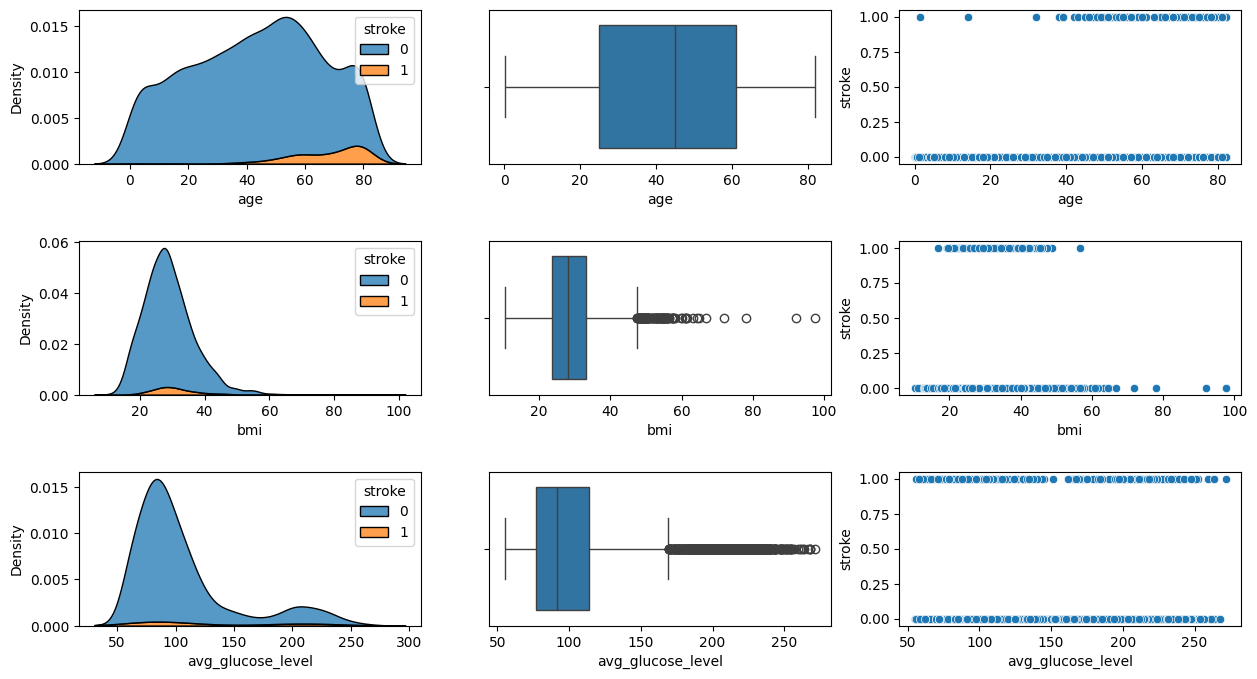

In [16]:
## 연속형 변수의 분포 확인
i = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
plt.subplots_adjust(hspace = 0.5)
for num_col in numeric_columns :
    sns.kdeplot(x=num_col, hue='stroke', data=df, multiple='stack', ax=ax[i,0])
    sns.boxplot(x=num_col, data=df, ax=ax[i, 1])
    sns.scatterplot(x=num_col, y='stroke', data=df, ax=ax[i, 2])
    i+=1
plt.show()

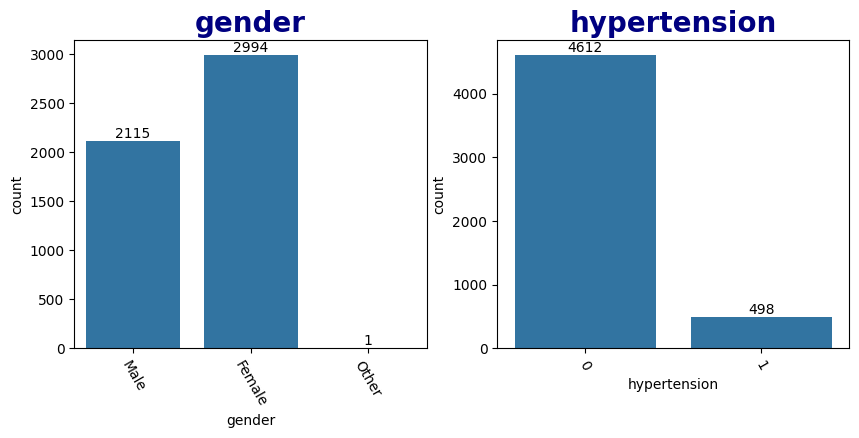

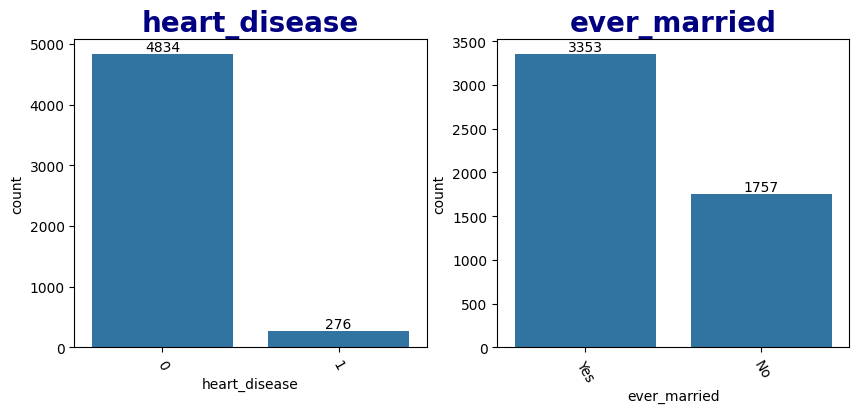

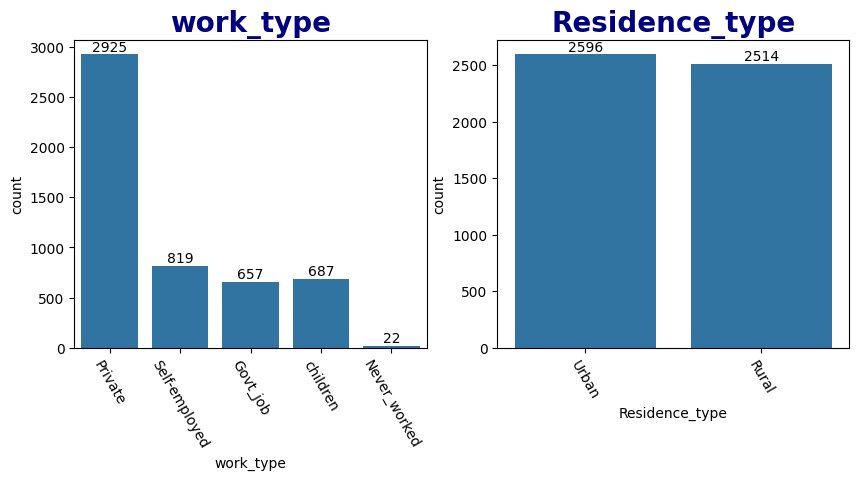

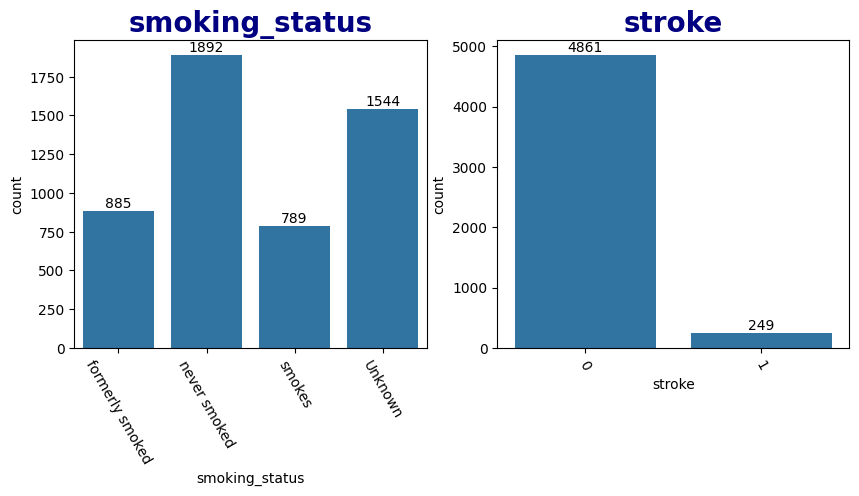

In [17]:
## 범주형 변수의 분포 확인
i=0
while i<8 :
    # Left AX
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
    ax = sns.countplot(x=categorical_columns[i], data=df)
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis='x', rotation=300)
    i+=1

    # Right AX
    plt.subplot(1, 2, 2)
    plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
    ax = sns.countplot(x=categorical_columns[i], data=df)
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis='x', rotation=300)
    i+=1
    plt.show()

In [18]:
y = df['stroke']
print(f'Percentage of patient had a stroke: % {round(y.value_counts(normalize=True)[1]*100,2)} --> ({y.value_counts()[1]} patient)')

Percentage of patient had a stroke: % 4.87 --> (249 patient)


## ***imbalanced data set이다!***

# **4. Data preprocessing**

## 1) Missing value handling

In [19]:
# 데이터의 특성, 사용하는 모델, 연구의 목적에 따라 처리방법 선택
# 하나라도 결측치를 가지고 있는 행은 모두 삭제
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(4909, 11)

In [20]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## 2) Dummy

In [21]:
df_2 = pd.get_dummies(df, columns=['work_type'], dtype='int', drop_first=True)
df_2.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1,0,1,0,0
1,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1,0,1,0,0
2,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1,0,1,0,0
3,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1,0,0,1,0
4,Male,81.0,0,0,Yes,Urban,186.21,29.0,formerly smoked,1,0,1,0,0


In [22]:
cols=df_2.columns
cols

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children'],
      dtype='object')

## 2) Unique value transformation
#### 범주형 변수들의 고유값 갯수를 세서 각 고유값을 정수값로 변경합니다.

In [ ]:
columns_temp = ['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']

for col in columns_temp :
    print('column :', col)
    for index, unique in enumerate(df[col].unique()) :
        print(unique, ':', index)
    print('_'*45)

column : gender
Male : 0
Female : 1
Other : 2
_____________________________________________
column : ever_married
Yes : 0
No : 1
_____________________________________________
column : work_type
Private : 0
Self-employed : 1
Govt_job : 2
children : 3
Never_worked : 4
_____________________________________________
column : smoking_status
formerly smoked : 0
never smoked : 1
smokes : 2
Unknown : 3
_____________________________________________
column : Residence_type
Urban : 0
Rural : 1
_____________________________________________


In [ ]:
# gender
df_2.replace({'gender' : {'Male' : 0, 'Female' : 1, 'Other' : 2}}, inplace=True)

# ever_married
df_2.replace({'ever_married' : {'Yes' : 0, 'No' : 1}}, inplace=True)

# smoking_status
df_2.replace({'smoking_status' : {'formerly smoked' : 0, 'never smoked' : 1, 'smokes' : 2, 'Unknown' : 3}}, inplace=True)

# Residence_type
df_2.replace({'Residence_type' : {'Urban' : 0, 'Rural' : 1}}, inplace=True)

df_2.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0,67.0,0,1,0,0,228.69,36.6,0,1,0,1,0,0
1,0,80.0,0,1,0,1,105.92,32.5,1,1,0,1,0,0
2,1,49.0,0,0,0,0,171.23,34.4,2,1,0,1,0,0
3,1,79.0,1,0,0,1,174.12,24.0,1,1,0,0,1,0
4,0,81.0,0,0,0,0,186.21,29.0,0,1,0,1,0,0


## 3) Train, test split

In [ ]:
split= StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)

for train_index, test_index in split.split(df_2[cols], df_2["stroke"]):
    X_train=df_2[cols].loc[train_index]
    y_train=df_2["stroke"].loc[train_index]
    X_test=df_2[cols].loc[test_index]
    y_test=df_2["stroke"].loc[test_index]

print('train set size:', X_train.shape)
print('test set size:', X_test.shape)
print('stroke in train set:', y_train.sum(), '명')
print('stroke in test set:', y_test.sum(), '명')

train set size: (3436, 14)
test set size: (1473, 14)
stroke in train set: 146 명
stroke in test set: 63 명


## 4) Normalization

In [ ]:
standardscaler = StandardScaler()
minmaxscaler = MinMaxScaler()

### Numerical variables

In [ ]:
standardscaler.fit(X_train[numeric_columns])
X_train[numeric_columns]=standardscaler.transform(X_train[numeric_columns])
X_test[numeric_columns]=standardscaler.transform(X_test[numeric_columns])

### Ordinal variables

In [ ]:
ordinal_columns=['smoking_status']
X_train[ordinal_columns] = minmaxscaler.fit_transform(X_train[ordinal_columns])
X_test[ordinal_columns] = minmaxscaler.transform(X_test[ordinal_columns])

# **5. Modeling**

In [ ]:
model_rtree=RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
model_lbm=lgb.LGBMClassifier(n_estimators=400, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def true_positives(y, pred, th=0.5):
    TP = 0
    thresholded_preds = pred >= th
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    return TP

def true_negatives(y, pred, th=0.5):
    TN = 0
    thresholded_preds = pred >= th
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    return TN

def false_positives(y, pred, th=0.5):
    FP = 0
    thresholded_preds = pred >= th
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    return FP

def false_negatives(y, pred, th=0.5):
    FN = 0
    thresholded_preds = pred >= th
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    return FN

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0
    TP = true_positives(y, pred, th = th)
    FP = false_positives(y, pred, th = th)
    TN = true_negatives(y, pred, th = th)
    FN = false_negatives(y, pred, th = th)
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    return accuracy

def get_sensitivity(y, pred, th=0.5):
    sensitivity = 0.0
    TP = true_positives(y, pred, th = th)
    FN = false_negatives(y, pred, th = th)
    sensitivity = TP/(TP + FN)
    return sensitivity

def get_specificity(y, pred, th=0.5):
    specificity = 0.0
    TN = true_negatives(y, pred, th = th)
    FP = false_positives(y, pred, th = th)
    specificity = TN/(TN + FP)
    return specificity

def get_ppv(y, pred, th=0.5):
    PPV = 0.0
    TP = true_positives(y, pred, th = th)
    FP = false_positives(y, pred, th = th)
    PPV = TP/(TP + FP)
    return PPV

def get_npv(y, pred, th=0.5):
    NPV = 0.0
    TN = true_negatives(y, pred, th = th)
    FN = false_negatives(y, pred, th = th)
    NPV = TN/(TN + FN)
    return NPV

def final_evaluation(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred_proba=model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    return y_pred_proba, y_pred

def get_metrics(y_pred, y_pred_proba, columns='modelname'):
    metrics_model=[]
    metrics_model.append(roc_auc_score(y_test, y_pred_proba[:,1]))
    metrics_all=[accuracy_score, get_sensitivity, get_specificity, get_ppv, get_npv, f1_score]
    for i in range(6):
        metric=metrics_all[i](y_test, y_pred)
        metrics_model.append(metric)
    print("AUC: %.3f" %roc_auc_score(y_test, y_pred_proba[:,1]))
    print(f"accuracy: %.3f" %accuracy_score(y_test, y_pred))
    print(f"sensitivity: %.3f" %get_sensitivity(y_test, y_pred))
    print(f"specificity: %.3f" %get_specificity(y_test, y_pred))
    print(f"PPV: %.3f" %get_ppv(y_test, y_pred))
    print(f"NPV: %.3f" %get_npv(y_test, y_pred))
    print(f"f1: %.3f" %f1_score(y_test, y_pred))
    return pd.DataFrame(metrics_model, columns=[columns])

In [ ]:
y_pred_rtree_proba, y_pred_rtree=final_evaluation(model_rtree, X_train, y_train, X_test)
metrics_model_rtree=get_metrics(y_pred_rtree, y_pred_rtree_proba, columns='rtree')

AUC: 1.000
accuracy: 0.999
sensitivity: 0.984
specificity: 1.000
PPV: 1.000
NPV: 0.999
f1: 0.992


In [ ]:
y_pred_lbm_proba, y_pred_lbm=final_evaluation(model_lbm, X_train, y_train, X_test)
metrics_model_lbm=get_metrics(y_pred_lbm, y_pred_lbm_proba, columns='lbm')

[LightGBM] [Info] Number of positive: 146, number of negative: 3290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 3436, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042491 -> initscore=-3.115036
[LightGBM] [Info] Start training from score -3.115036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

# **6. Model Evaluation**

## 1) AUROC

<ipython-input-38-f058e99dbac1>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-whitegrid'])


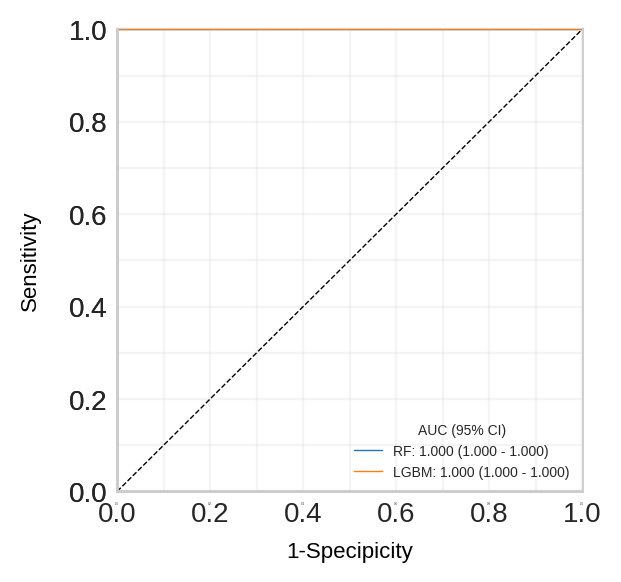

In [ ]:
from math import sqrt

def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

plt.style.use(['seaborn-whitegrid'])
fig=plt.figure(figsize=(3, 3), dpi=200)
fig.set_facecolor('white')
plt.xticks(fontsize=1)
ax = fig.add_subplot()
grid_x_ticks = np.arange(0, 1, 0.1)
grid_y_ticks = np.arange(0, 1, 0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(grid_x_ticks , minor=True)
ax.set_yticks(grid_y_ticks , minor=True)

plt.plot([0, 1], [0, 1],'k--', linewidth=0.5)

w=0.5

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rtree_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_pred_rtree_proba[:,1])
low, high=roc_auc_ci(y_test, y_pred_rtree_proba[:,1], positive=1)
plt.plot(fpr,tpr,label="RF: "+'{:.3f} ({:.3f} - {:.3f})'.format(auc, low, high), linewidth=w)

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_lbm_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_pred_lbm_proba[:,1])
low, high=roc_auc_ci(y_test, y_pred_lbm_proba[:,1], positive=1)
plt.plot(fpr,tpr,label="LGBM: "+'{:.3f} ({:.3f} - {:.3f})'.format(auc, low, high), linewidth=w)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, alpha=0.2, which='both')

plt.title('')
plt.ylabel('Sensitivity', labelpad=10, fontdict={'color': 'k', 'size': 8})
plt.xlabel('1-Specipicity', labelpad=5, fontdict={'color': 'k', 'size': 8})
legend=plt.legend(loc=4, frameon=False, prop={'size':5})
legend.set_title("AUC (95% CI)", prop = {'size':5})
plt.show()

## 2) confusion matrix

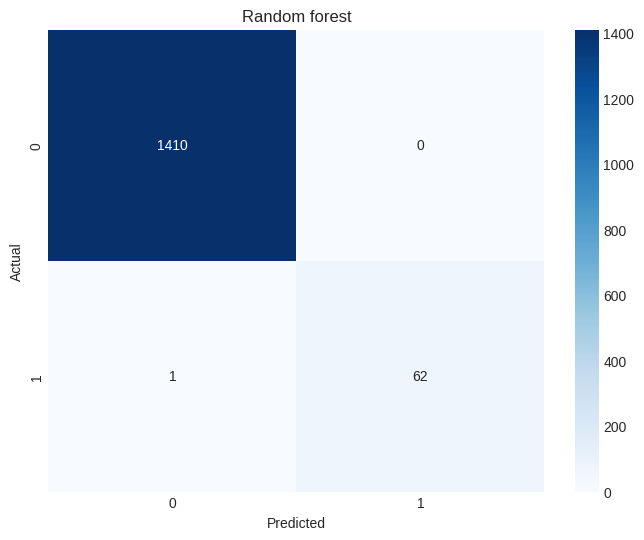

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rtree})
contingency_table = pd.crosstab(df['Actual'], df['Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random forest')

plt.show()

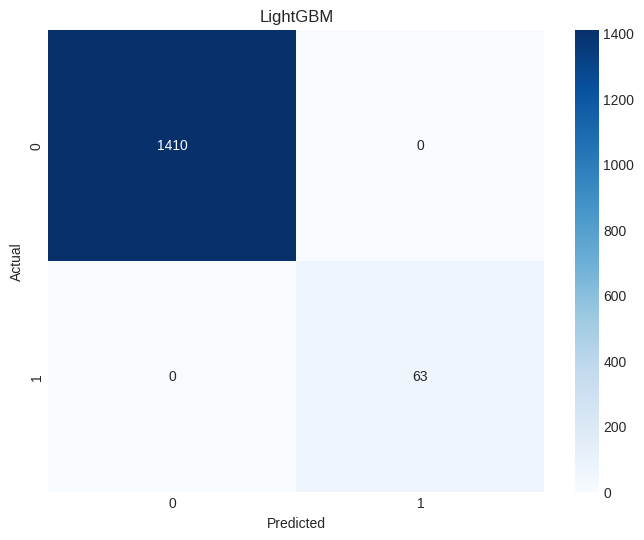

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lbm})
contingency_table = pd.crosstab(df['Actual'], df['Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM')

plt.show()